In [1]:
import sys
sys.path.append('..') 
from model_architectures import *
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, OneCycleLR
from collections import Counter
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
height, width = 10, 10
# height, width = 64, 64

Using device: cuda


In [2]:
# Enable GPU usage for faster training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print(f"Using device: {device}")

Using device: cuda


In [3]:
model = Autoencoder10()
model.to(device)

# %%  
# Read the CSV file with specified data types
data = pd.read_csv(f"../archive/ascii_character_classification_{height}_x_{width}.csv", header=0)

label_counts = Counter(data.iloc[:, 0])
print(label_counts)

Counter({0: 50000, 51: 4886, 26: 4856, 54: 4848, 12: 4834, 58: 4833, 90: 4831, 31: 4827, 32: 4826, 62: 4825, 83: 4825, 60: 4823, 64: 4819, 56: 4819, 77: 4818, 79: 4816, 88: 4810, 80: 4806, 65: 4806, 92: 4804, 85: 4802, 20: 4800, 55: 4798, 93: 4795, 71: 4791, 45: 4789, 36: 4785, 22: 4783, 9: 4783, 34: 4782, 1: 4780, 5: 4779, 37: 4778, 33: 4777, 72: 4777, 70: 4775, 29: 4772, 40: 4770, 23: 4769, 35: 4769, 15: 4765, 69: 4764, 49: 4761, 8: 4759, 39: 4755, 73: 4746, 7: 4745, 59: 4741, 50: 4740, 4: 4740, 66: 4737, 87: 4735, 76: 4734, 44: 4731, 86: 4730, 74: 4727, 57: 4726, 28: 4724, 61: 4722, 82: 4719, 30: 4717, 21: 4714, 13: 4714, 89: 4713, 14: 4712, 10: 4699, 2: 4696, 18: 4695, 38: 4694, 81: 4693, 68: 4690, 91: 4690, 84: 4688, 3: 4688, 95: 4688, 53: 4687, 17: 4683, 16: 4682, 24: 4678, 75: 4677, 6: 4673, 46: 4665, 63: 4661, 27: 4642, 19: 4639, 43: 4631, 78: 4625, 11: 4624, 47: 4621, 41: 4619, 42: 4604, 67: 4603, 25: 4586, 48: 4584, 52: 4582, 94: 4576})


In [4]:
# Prepare the data
X = data.iloc[:, 1:].astype("float64")   # Features are all columns except the first one
y = data.iloc[:, 0].astype("float64")     # Labels are the first column

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

# Optionally, if you want to convert them back to pandas DataFrames:
train_data = pd.concat([y_train, X_train], axis=1)
test_data = pd.concat([y_test, X_test], axis=1)

In [5]:
print(chr(12+32))

,


In [6]:
train_labels = train_data.iloc[:, 0].values    
train_images = train_data.iloc[:, 1:].values 

test_labels = test_data.iloc[:, 0].values 
test_images = test_data.iloc[:, 1:].values 

# Convert to PyTorch tensors
train_images_tensor = torch.tensor(train_images, dtype=torch.float32)
test_images_tensor = torch.tensor(test_images, dtype=torch.float32)


In [7]:
# Reshape the images to [batch_size, 1, height, width]
train_images_tensor = train_images_tensor.view(-1, 1, height, width)
test_images_tensor = test_images_tensor.view(-1, 1, height, width)

print(train_images_tensor.shape)
print(test_images_tensor.shape)

# Create DataLoader for the train and test datasets
batch_size = 256
train_dataset = TensorDataset(train_images_tensor, train_images_tensor)  # Autoencoder target is the same as input
test_dataset = TensorDataset(test_images_tensor, test_images_tensor)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Move the data to the GPU
train_images_tensor, test_images_tensor = train_images_tensor.to(device), test_images_tensor.to(device)


torch.Size([400000, 1, 10, 10])
torch.Size([100000, 1, 10, 10])


In [8]:
criterion = nn.MSELoss()  # For autoencoder, we use MSE loss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)  # Adjust step_size and gamma as needed

# Compute Train Accuracy (for reconstruction, we can visualize the results)
def compute_reconstruction_loss(model, data_loader, device):
    total_loss = 0
    num_batches = 0
    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)
            _, decoded = model(images)
            loss = criterion(decoded, images)
            total_loss += loss.item()
            num_batches += 1
    return total_loss / num_batches

In [9]:
train_losses = []

# Training the model
num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0
    epoch_losses = []

    for i, (images, _) in enumerate(train_loader):
        optimizer.zero_grad()

        # Move data to the GPU
        images = images.to(device)
        # print(images.shape)
        _, decoded = model(images)
        
        # print(decoded.shape)
        # Calculate loss between the input and the reconstructed image
        loss = criterion(decoded, images)
        loss.backward()

        optimizer.step()

        epoch_losses.append(loss.item())
        total_loss += loss.item()

    scheduler.step()
    
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

print('Training finished.')

Epoch [1/10], Loss: 0.0317
Epoch [2/10], Loss: 0.0244
Epoch [3/10], Loss: 0.0226
Epoch [4/10], Loss: 0.0215
Epoch [5/10], Loss: 0.0208
Epoch [6/10], Loss: 0.0200
Epoch [7/10], Loss: 0.0197
Epoch [8/10], Loss: 0.0194
Epoch [9/10], Loss: 0.0192
Epoch [10/10], Loss: 0.0190
Training finished.


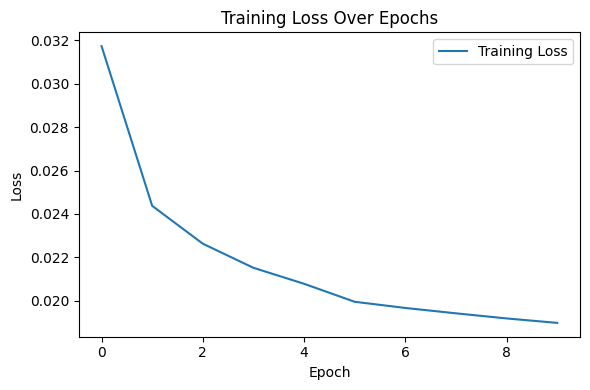

In [10]:
# Plotting training losses
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


In [11]:
# Save the model
torch.save(model.state_dict(), f'../artifacts/autoencoder_ascii_{height}_x_{width}.pth')


In [12]:
# Evaluate the model on the test data
model.eval()  # Set the model to evaluation mode

test_loss = compute_reconstruction_loss(model, test_loader, device)
print(f'Test Loss: {test_loss:.4f}')

Test Loss: 0.0188


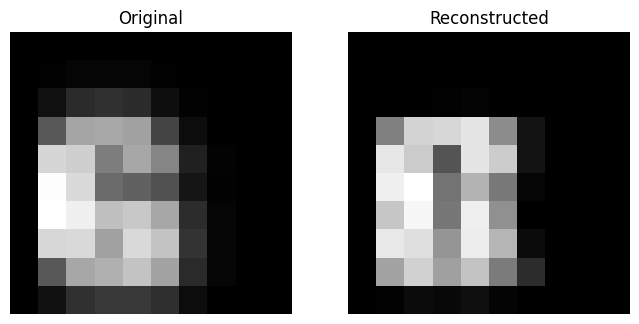

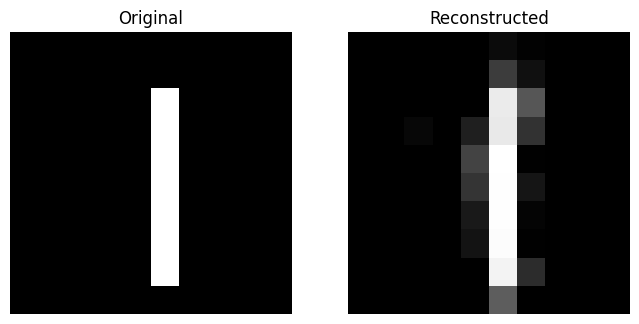

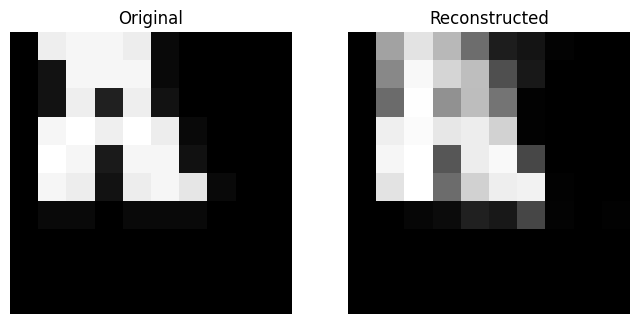

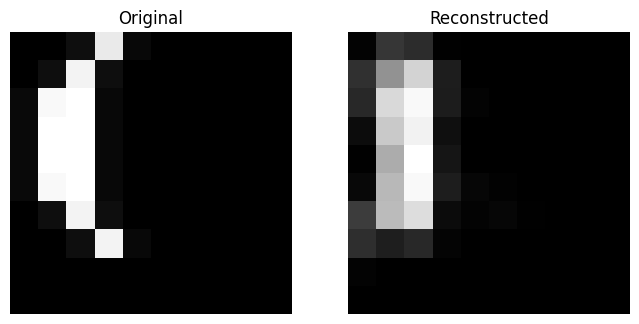

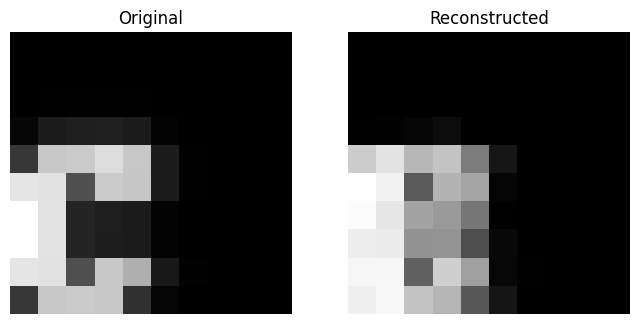

In [13]:
# Visualize some test results
import numpy as np

with torch.no_grad():
    for i, (images, _) in enumerate(test_loader):
        images = images.to(device)
        _, decoded = model(images)
        decoded_images = decoded.cpu().numpy()
        images = images.cpu().numpy()
        
        # Show the first few original and reconstructed images
        for j in range(5):
            fig, ax = plt.subplots(1, 2, figsize=(8, 4))
            ax[0].imshow(images[j, 0], cmap='gray')
            ax[0].set_title('Original')
            ax[0].axis('off')
            ax[1].imshow(decoded_images[j, 0], cmap='gray')
            ax[1].set_title('Reconstructed')
            ax[1].axis('off')
            plt.show()
        break